# Predictive Modeling on Cancer Data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [180]:
cancer = pd.read_csv("Breast Invasive Carcinoma (TCGA, Provisional).csv")

In [143]:
cancer['ETHNICITY'].value_counts().index[0]

'NOT HISPANIC OR LATINO'

In [181]:
target_threshold = 30
cancer["survival"] = ""

In [182]:
def setup_target_variable(df, target_column, new_column, threshold):
    '''Changes the target variable values based on the threshold'''

    #df.loc[df[target_column].values > threshold, new_column] = 0    # 1 - above the threshold
    #df.loc[(df[target_column].values <= threshold) & (df['OS STATUS'] == 'DECEASED'), new_column] = 1   # 0 - below the threshold
    #df= df[~((df['OS STATUS'] == 'LIVING') & (df[target_column] <= threshold))]
    df[new_column] = np.logical_and(df['OS STATUS'] == 'DECEASED', df[target_column] <= threshold)
    
    return df 

In [183]:
cancer = setup_target_variable(cancer, 'OS MONTHS', 'survival', target_threshold)

In [184]:
print cancer.survival.value_counts()

False    1063
True       42
dtype: int64


In [185]:
features_chosen_by_domain_knowledge = ['AGE', 'AJCC METASTASIS PATHOLOGIC PM', 'AJCC NODES PATHOLOGIC PN', 'AJCC PATHOLOGIC TUMOR STAGE', 'AJCC TUMOR PATHOLOGIC PT', 'ETHNICITY', 'GENDER', 'CNA', 'INITIAL WEIGHT', 'HISTORY NEOADJUVANT TRTYN', 'HISTORY OTHER MALIGNANCY', 'LYMPH NODES EXAMINED', 'Mutation Count','ICD 10', 'ICD O 3 HISTOLOGY', 'ICD O 3 SITE']

In [187]:
def convert_categorical_to_int(df, column_name):
	'''Convert categorical values into integers'''	

	categorical_values = df[column_name].value_counts().index.tolist()
	assigned_value = 0
	for value in categorical_values:
		df.loc[df[column_name] == value, column_name] = assigned_value
		assigned_value += 1

	return df

def handle_categorical_variables(df, list_of_columns):
    '''Converts the categorical variables in the list of columns to integers'''
    
    for column in list_of_columns:
        df = convert_categorical_to_int(df, column)
    
    return df

In [188]:

cancer = handle_categorical_variables(cancer, ['AJCC METASTASIS PATHOLOGIC PM', 'AJCC NODES PATHOLOGIC PN', 'AJCC PATHOLOGIC TUMOR STAGE', 'AJCC TUMOR PATHOLOGIC PT', 'ETHNICITY', 'GENDER', 'HISTORY NEOADJUVANT TRTYN', 'HISTORY OTHER MALIGNANCY', 'ICD 10', 'ICD O 3 HISTOLOGY', 'ICD O 3 SITE'])


In [196]:
print cancer['AGE'].median()

58.0


In [197]:
def handle_na(df):
    '''Handle the NaN fields'''

    df['AGE'].fillna(df['AGE'].mean(), inplace = True)
    df['Mutation Count'].fillna(df['Mutation Count'].median(), inplace = True)
    df['CNA'].fillna(df['CNA'].mean(), inplace = True)
    df['LYMPH NODES EXAMINED'].fillna(df['LYMPH NODES EXAMINED'].mean(), inplace = True)
    df['INITIAL WEIGHT'].fillna(df['INITIAL WEIGHT'].mean(), inplace = True)
    df['AJCC METASTASIS PATHOLOGIC PM'].fillna(df['AJCC METASTASIS PATHOLOGIC PM'].value_counts().index[0], inplace = True)
    df['AJCC NODES PATHOLOGIC PN'].fillna(df['AJCC NODES PATHOLOGIC PN'].value_counts().index[0], inplace = True)
    df['AJCC PATHOLOGIC TUMOR STAGE'].fillna(df['AJCC PATHOLOGIC TUMOR STAGE'].value_counts().index[0], inplace = True)
    df['AJCC TUMOR PATHOLOGIC PT'].fillna(df['AJCC TUMOR PATHOLOGIC PT'].value_counts().index[0], inplace = True)
    df['ETHNICITY'].fillna(df['ETHNICITY'].value_counts().index[0], inplace = True)
    df['GENDER'].fillna(df['GENDER'].value_counts().index[0], inplace = True)
    df['HISTORY NEOADJUVANT TRTYN'].fillna(df['HISTORY NEOADJUVANT TRTYN'].value_counts().index[0], inplace = True)
    df['HISTORY OTHER MALIGNANCY'].fillna(df['HISTORY OTHER MALIGNANCY'].value_counts().index[0], inplace = True)
    df['ICD 10'].fillna(df['ICD 10'].value_counts().index[0], inplace = True)
    df['ICD O 3 HISTOLOGY'].fillna(df['ICD O 3 HISTOLOGY'].value_counts().index[0], inplace = True)
    df['ICD O 3 SITE'].fillna(df['ICD O 3 SITE'].value_counts().index[0], inplace = True)
    
    return df 

In [202]:
print cancer['CNA'].mean()

0.296227235984


In [199]:
cancer = handle_na(cancer)

print "Shape(Before removing NaN): ", cancer.shape
cancer_without_nan = cancer.dropna(subset = ['OS MONTHS'])
print "Shape(After removing NaN): ", cancer_without_nan.shape

#cancer_without_nan = cancer_without_nan.convert_objects(convert_dates=False, convert_numeric=True, convert_timedeltas=False, copy=True)

Shape(Before removing NaN):  (1105, 59)
Shape(After removing NaN):  (1006, 59)


In [155]:
cancer_without_nan['ETHNICITY'].value_counts()

0    962
1     36
2      7
3      1
dtype: int64

In [19]:
np.unique(cancer_without_nan.survival)

array([0, 1], dtype=object)

In [225]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import grid_search
import matplotlib.pyplot as plt
%matplotlib inline

In [256]:
def decision_tree_model_with_cv(training_data, target_data, k, leaf, split):
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = split, min_samples_leaf = leaf)
    cv_score_auc = cross_val_score(decision_tree, training_data, target_data, scoring = 'roc_auc', cv=k)
    cv_score_f1 = cross_val_score(decision_tree, training_data, target_data, scoring = 'f1', cv=k)
    cv_score_precision = cross_val_score(decision_tree, training_data, target_data, scoring = 'precision', cv=k)
    
    #plt.plot(range(len(cv_score_auc)), cv_score_auc, 'r', label = 'DT (Mean: %.2f)' % (cv_score_auc.mean()))
    
    return cv_score_auc.mean(), cv_score_auc.std(), cv_score_f1.mean(), cv_score_precision.mean()

In [257]:
def logistic_regression_model_with_cv(training_data, target_data, k, c):
    lr = LogisticRegression(C=c)
    cv_score_auc = cross_val_score(lr, training_data, target_data, scoring = 'roc_auc', cv=k)
    cv_score_f1 = cross_val_score(lr, training_data, target_data, scoring = 'f1', cv=k)
    cv_score_precision = cross_val_score(lr, training_data, target_data, scoring = 'precision', cv=k)
    
    #plt.plot(range(len(cv_score_auc)), cv_score_auc, 'g', label = 'LR (Mean: %.2f)' % (cv_score_auc.mean()))
    
    return cv_score_auc.mean(), cv_score_auc.std(), cv_score_f1.mean(), cv_score_precision.mean()

In [258]:
def svm_model_with_cv(training_data, target_data, k, c):
    svm = SVC(C=c)
    cv_score_auc = cross_val_score(svm, training_data, target_data, scoring = 'roc_auc', cv=k)
    cv_score_f1 = cross_val_score(svm, training_data, target_data, scoring = 'f1', cv=k)
    cv_score_precision = cross_val_score(svm, training_data, target_data, scoring = 'precision', cv=k)
    
    #plt.plot(range(len(cv_score_auc)), cv_score_auc, 'b', label = 'SVM (Mean: %.2f)' % (cv_score_auc.mean()))
    
    return cv_score_auc.mean(), cv_score_auc.std(), cv_score_f1.mean(), cv_score_precision.mean()

In [259]:
def rf_model_with_cv(training_data, target_data, k, n_est):
    rf = RandomForestClassifier(n_estimators = n_est, criterion = "entropy")
    cv_score_auc = cross_val_score(rf, training_data, target_data.astype(int), scoring = 'roc_auc', cv=k)
    cv_score_f1 = cross_val_score(rf, training_data, target_data.astype(int), scoring = 'f1', cv=k)
    cv_score_precision = cross_val_score(rf, training_data, target_data.astype(int), scoring = 'precision', cv=k)
    
    #plt.plot(range(len(cv_score_auc)), cv_score_auc, 'c', label = 'RF (Mean: %.2f)' % (cv_score_auc.mean()))
    
    return cv_score_auc.mean(), cv_score_auc.std(), cv_score_f1.mean(), cv_score_precision.mean()

In [205]:
# Setting up the data for finding optimal hyperparameters

final_features = features_chosen_by_domain_knowledge + ['survival']
cancer_without_nan = cancer_without_nan[final_features]

dead_people = cancer_without_nan[cancer_without_nan['survival'] == True]
alive_people = cancer_without_nan[cancer_without_nan['survival'] == False]

dead_train, dead_test = train_test_split(dead_people, train_size = 0.8)
alive_train, alive_test = train_test_split(alive_people, train_size = 0.8)

training = pd.concat([dead_train, alive_train])
test = pd.concat([dead_test, alive_test])

cancer_training = training.drop('survival', 1)
cancer_testing = test.drop('survival', 1)
survival_training = training['survival']
survival_testing = test['survival']

print cancer_training.shape
print cancer_testing.shape
print survival_training.shape
print survival_testing.shape

(804, 16)
(202, 16)
(804,)
(202,)


In [124]:
cancer_testing['ETHNICITY'].value_counts()

0      148
800     46
1        7
2        1
dtype: int64

(AUC, F-Score, Precision)
Decision Tree:  (0.57285839160839158, 0.068571428571428575, 0.083333333333333329)
Logistic Regression:  (0.66222943722943728, 0.0, 0.0)
SVM:  (0.62466699966699957, 0.0, 0.0)
Random Forest:  (0.67797619047619051, 0.080000000000000002, 0.050000000000000003)


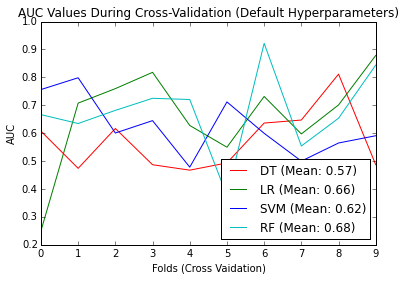

In [244]:
dt_with_cv = decision_tree_model_with_cv(cancer_training, survival_training, 10, 2, 1)
lr_with_cv = logistic_regression_model_with_cv(cancer_training, survival_training, 10, 1.0)
svm_with_cv = svm_model_with_cv(cancer_training, survival_training, 10, 1.0)
rf_with_cv = rf_model_with_cv(cancer_training, survival_training, 10, 10)

plt.xlabel("Folds (Cross Vaidation)")
plt.ylabel("AUC")
plt.title('AUC Values During Cross-Validation (Default Hyperparameters)')
plt.legend(loc = 'lower right')

print "(AUC, F-Score, Precision)"
print "Decision Tree: ", dt_with_cv
print "Logistic Regression: ", lr_with_cv
print "SVM: ", svm_with_cv
print "Random Forest: ", rf_with_cv

In [13]:
# Decision Tree Model Hyperparameters
class DT_HyperParam:
    
    def __init__(self, max_depth, min_samples_split, min_samples_leaf, max_features):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        
    def get_max_depth(self):
        return self.max_depth
    
    def get_min_samples_split(self):
        return self.min_samples_split
    
    def get_min_samples_leaf(self):
        return self.min_samples_leaf
    
    def get_max_features(self):
        return self.max_features

In [281]:
# Searching optimal hyperparameters for SVM
powers_svm = np.arange(-2, 2, 0.2)
cs_svm = [10**exp for exp in powers_svm]
cv_auc_svm_mean = []
cv_auc_svm_std = []

for C_svm in cs_svm:
    cv_auc_svm = svm_model_with_cv(cancer_training, survival_training, 10, C_svm)
    cv_auc_svm_mean.append(cv_auc_svm[0])
    cv_auc_svm_std.append(cv_auc_svm[1])

The optimal value of C for SVM is 10^-0.200000


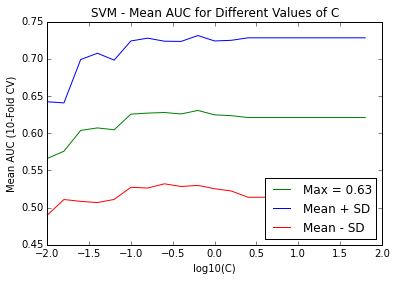

In [290]:
plt.plot(np.log10(cs_svm), cv_auc_svm_mean, 'g', label = "Max = %.2f" % (max(cv_auc_svm_mean)))
plt.plot(np.log10(cs_svm), [x + y for (x, y) in zip(cv_auc_svm_mean, cv_auc_svm_std)], 'b', label = 'Mean + SD')
plt.plot(np.log10(cs_svm), [x - y for (x, y) in zip(cv_auc_svm_mean, cv_auc_svm_std)], 'r', label = 'Mean - SD')
plt.xlabel("log10(C)")
plt.ylabel("Mean AUC (10-Fold CV)")
plt.legend(loc = 'lower right')
plt.title("SVM - Mean AUC for Different Values of C")
plt.savefig('svm_optimal_C.png')

print "The optimal value of C for SVM is 10^%f" % powers_svm[cv_auc_svm_mean.index(max(cv_auc_svm_mean))]

In [283]:
# Searching optimal hyperparameters for Logistic Regression
powers_lr = np.arange(-1, 5, 0.5)
cs_lr = [10**exp for exp in powers_lr]
cv_auc_lr_mean = []
cv_auc_lr_std = []

for C_lr in cs_lr:
    cv_auc_lr = logistic_regression_model_with_cv(cancer_training, survival_training, 10, C_lr)
    cv_auc_lr_mean.append(cv_auc_lr[0])
    cv_auc_lr_std.append(cv_auc_lr[1])

The optimal value of C for LR is 10^3.000000


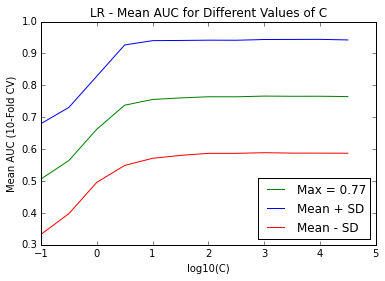

In [289]:
plt.plot(np.log10(cs_lr), cv_auc_lr_mean, 'g', label = "Max = %.2f" % (max(cv_auc_lr_mean)))
plt.plot(np.log10(cs_lr), [x + y for (x, y) in zip(cv_auc_lr_mean, cv_auc_lr_std)], 'b', label = 'Mean + SD')
plt.plot(np.log10(cs_lr), [x - y for (x, y) in zip(cv_auc_lr_mean, cv_auc_lr_std)], 'r', label = 'Mean - SD')
plt.xlabel("log10(C)")
plt.ylabel("Mean AUC (10-Fold CV)")
plt.legend(loc = 'lower right')
plt.title("LR - Mean AUC for Different Values of C")
plt.savefig('lr_optimal_C.png')


print "The optimal value of C for LR is 10^%f" % powers_lr[cv_auc_lr_mean.index(max(cv_auc_lr_mean))]

In [295]:
# Testing LR

lr = LogisticRegression(C=10**3)
survival_predicted = lr.fit(cancer_training, survival_training).predict_proba(cancer_testing)
survival = lr.fit(cancer_training, survival_training).predict(cancer_testing)
lr_auc_score = roc_auc_score(survival_testing, survival_predicted[:, 1])

print "", lr_score

0.807138744963


In [294]:
from sklearn.metrics import classification_report

target_names = ['True', 'False']
print (classification_report(survival_testing, survival, target_names = target_names))

             precision    recall  f1-score   support

       True       0.96      0.98      0.97       193
      False       0.25      0.11      0.15         9

avg / total       0.93      0.95      0.94       202

